# Clustering first attempt

In [14]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns

# import dataset
df_original_copy = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True)
df = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True) #this will be modified

In [27]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [15]:
#Changing udm to duration_ms and features_duration_ms from ms to min
df['duration_ms'] *= 1/6e4
df.rename(columns = {'duration_ms':'duration_min'}, inplace = True)

In [16]:
#Creating genre map -> mapping every genre into an int value in order to have correlation values. 
#Redoing Pearson correlation adding genre category
df['genre'].value_counts()
genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}
df.replace({'genre':genre_map}).corr(numeric_only=True).style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1) #!!!

,duration_min,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
duration_min,1.000000,-0.048723,-0.076202,-0.080932,0.102996,0.016712,0.039403,-0.023310,-0.074774,-0.184902,0.079685,-0.021184,-0.141938,0.048765,0.999918,0.009033,0.839313,0.838041,-0.005830,-0.010400,0.030701
explicit,-0.048723,1.000000,-0.013096,0.056992,0.124405,-0.000991,0.131777,-0.042846,0.294287,-0.113975,-0.125101,0.006995,0.008631,0.016972,-0.048699,0.051260,-0.039830,-0.039435,0.029119,-0.005878,-0.031463
popularity,-0.076202,-0.013096,1.000000,0.051046,-0.056547,-0.008992,0.046703,0.073043,-0.096382,0.078424,-0.266843,0.027105,0.077652,-0.024162,-0.076228,-0.003160,-0.084774,-0.089134,-0.003665,0.008733,0.035557
danceability,-0.080932,0.056992,0.051046,1.000000,0.193940,0.035311,0.385244,-0.072422,0.111454,-0.199082,-0.202316,-0.174193,0.559578,0.092267,-0.080891,0.292167,-0.033604,-0.069332,0.011602,-0.026273,-0.125284
energy,0.102996,0.124405,-0.056547,0.193940,1.000000,0.057815,0.720907,-0.079969,0.143454,-0.699454,-0.203111,0.191024,0.284069,0.331538,0.102985,0.204646,0.243586,0.208615,0.040022,-0.037847,0.236734
key,0.016712,-0.000991,-0.008992,0.035311,0.057815,1.000000,0.047718,-0.157515,0.018157,-0.049867,-0.001532,-0.007420,0.028221,0.022414,0.016786,0.028388,0.027133,0.022042,0.019790,-0.490366,0.018896
loudness,0.039403,0.131777,0.046703,0.385244,0.720907,0.047718,1.000000,-0.033544,0.109793,-0.552519,-0.447106,0.047502,0.377743,0.308203,0.039415,0.250568,0.165565,0.131064,0.049174,-0.020563,0.119055
mode,-0.023310,-0.042846,0.073043,-0.072422,-0.079969,-0.157515,-0.033544,1.000000,-0.064289,0.085246,-0.080035,0.015738,-0.006907,-0.013001,-0.023409,-0.019378,-0.030685,-0.027687,0.003698,0.261129,0.056051
speechiness,-0.074774,0.294287,-0.096382,0.111454,0.143454,0.018157,0.109793,-0.064289,1.000000,-0.087997,-0.115803,0.050034,0.056068,0.062161,-0.074722,0.080739,-0.043217,-0.040820,0.026399,-0.022909,-0.118012
acousticness,-0.184902,-0.113975,0.078424,-0.199082,-0.699454,-0.049867,-0.552519,0.085246,-0.087997,1.000000,0.094256,-0.075924,-0.131961,-0.244244,-0.184846,-0.139706,-0.283324,-0.248164,-0.021155,0.022684,-0.196470


## Clustering searching for genre division 
I want to cluster considering only 'musical features', that are the 'technical' ones. The idea is to find the already-given division by genre.  
It is interesting, in case this works, to do a **hierarchical clustering** in order to search for 'base' genres and subgenres. 

The interesting features for the scope could be:
- `duration_min`
- `key` (discrete); 
- `mode` (discrete);
- `speechiness`;
- `acousticness`;
- `instrumentalness`;
- `tempo`;
- `time_signature`;
- `n_beats`;
- `n_bars`;  
being the latter two highly correlated with `duration_ms`, just the former is necessary. 
also `genre` in order to check the results.  
Being those the interesting attributes, a goal-specific data understanding will be done only on this data. 

### Outlier criterion
The outlier criterion for the following scope is composed by the following cut:
- `time_sigmature` > 1.0, in order to select only _music tracks_, where the features taken into spot are all well-defined;
- the first criterion ideally is enough but `sleep` tracks containing noise sounds often are bad-detected by the algorithm. Bc of that, in this first phase the `sleep` tracks are all excluded. 

### Data preparation

In [18]:
#Dealing with mode attribute missing values
#Computing p0 and p1 and filling missing values of mode attribute by sampling
#df['mode'].value_counts().plot(kind='bar', title='mode')
p0=df['mode'].value_counts()[0]/(len(df)-df['mode'].isnull().sum())
p1=df['mode'].value_counts()[1]/(len(df)-df['mode'].isnull().sum())
#print(f'p0={p0} , p1={p1}')
list_of_nan_indexes=df[df['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes:
    #df.loc[i,'mode']
    #df.loc[['viper', 'sidewinder'], ['shield']] = 50
    if np.random.random() < p1:
        df.loc[i,'mode'] = 1.0
    else:
        df.loc[i,'mode'] = 0.0

In [19]:
#Dealing with time_signature attribute missing values
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df['time_signature'].value_counts())
p_array=np.array(df['time_signature'].value_counts().sort_index(ascending=True)/(len(df)-df['time_signature'].isnull().sum()))
print(p_array)
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df[df['time_signature'].isnull()].index.tolist()
#print(list_of_nan_indexes)
print(len(list_of_nan_indexes_ts))
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df.loc[i,'time_signature'] = dict_ts[index]

[0.00711084 0.01151646 0.08981295 0.86257536 0.02898439]
2062


In [46]:
#Deleting outliers
df = df[(df['time_signature'] >1) & (df['genre'].str.contains('sleep')==False)]

In [47]:
#Selecting only the specific columns for the dataset
dfc=df[['duration_min','key', 'mode','speechiness','acousticness','instrumentalness','tempo','time_signature']]
dfc

,duration_min,key,mode,speechiness,acousticness,instrumentalness,tempo,time_signature
0,4.029333,5,1.0,0.0975,0.302000,0.536000,142.221,4.0
1,7.400000,1,0.0,0.0805,0.283000,0.934000,75.596,4.0
2,5.558433,2,1.0,0.0397,0.000089,0.800000,116.628,4.0
3,4.496667,5,1.0,0.0765,0.066400,0.001270,140.880,4.0
4,5.127517,7,1.0,0.0539,0.000576,0.096900,143.956,4.0
...,...,...,...,...,...,...,...,...
14994,3.750700,1,0.0,0.0700,0.033400,0.002890,175.017,4.0
14995,7.200433,1,1.0,0.0558,0.016000,0.615000,117.319,3.0
14997,6.668183,1,0.0,0.0594,0.001830,0.857000,126.000,4.0
14998,3.287500,5,1.0,0.0531,0.000337,0.000014,160.044,4.0


### Measure definition
Being some of those attributes _categorical_, such as `time_signature`, it is necessary to define a custom distance, that encorporates the Euclidean distance for continuous attributes and the dissimilarity concept of distance for categorical attributes.

In [24]:
# Defining the metric
# When the attribute is continuous, then the euclidean measure is used,
# when the attribute is categorical, dissimilarity is computed. 
# In order to distinguish the kind of attribute for the metric, 
# a dict is created, it will be used inside the metric function.
attribute_type_dict = {'key':'categorical','mode':'categorical','speechiness':'continuous',
                       'acousticness':'continuous','instrumentalness':'continuous',
                       'tempo':'continuous','time_signature':'categorical'}  


### Normalization (or, standardization)
It is necessary to choose a type of normalization. Looking at the distributions of the attributes for the scope, it is possible to decide with some criteria, see: https://developers.google.com/machine-learning/data-prep/transform/normalization?hl=en .

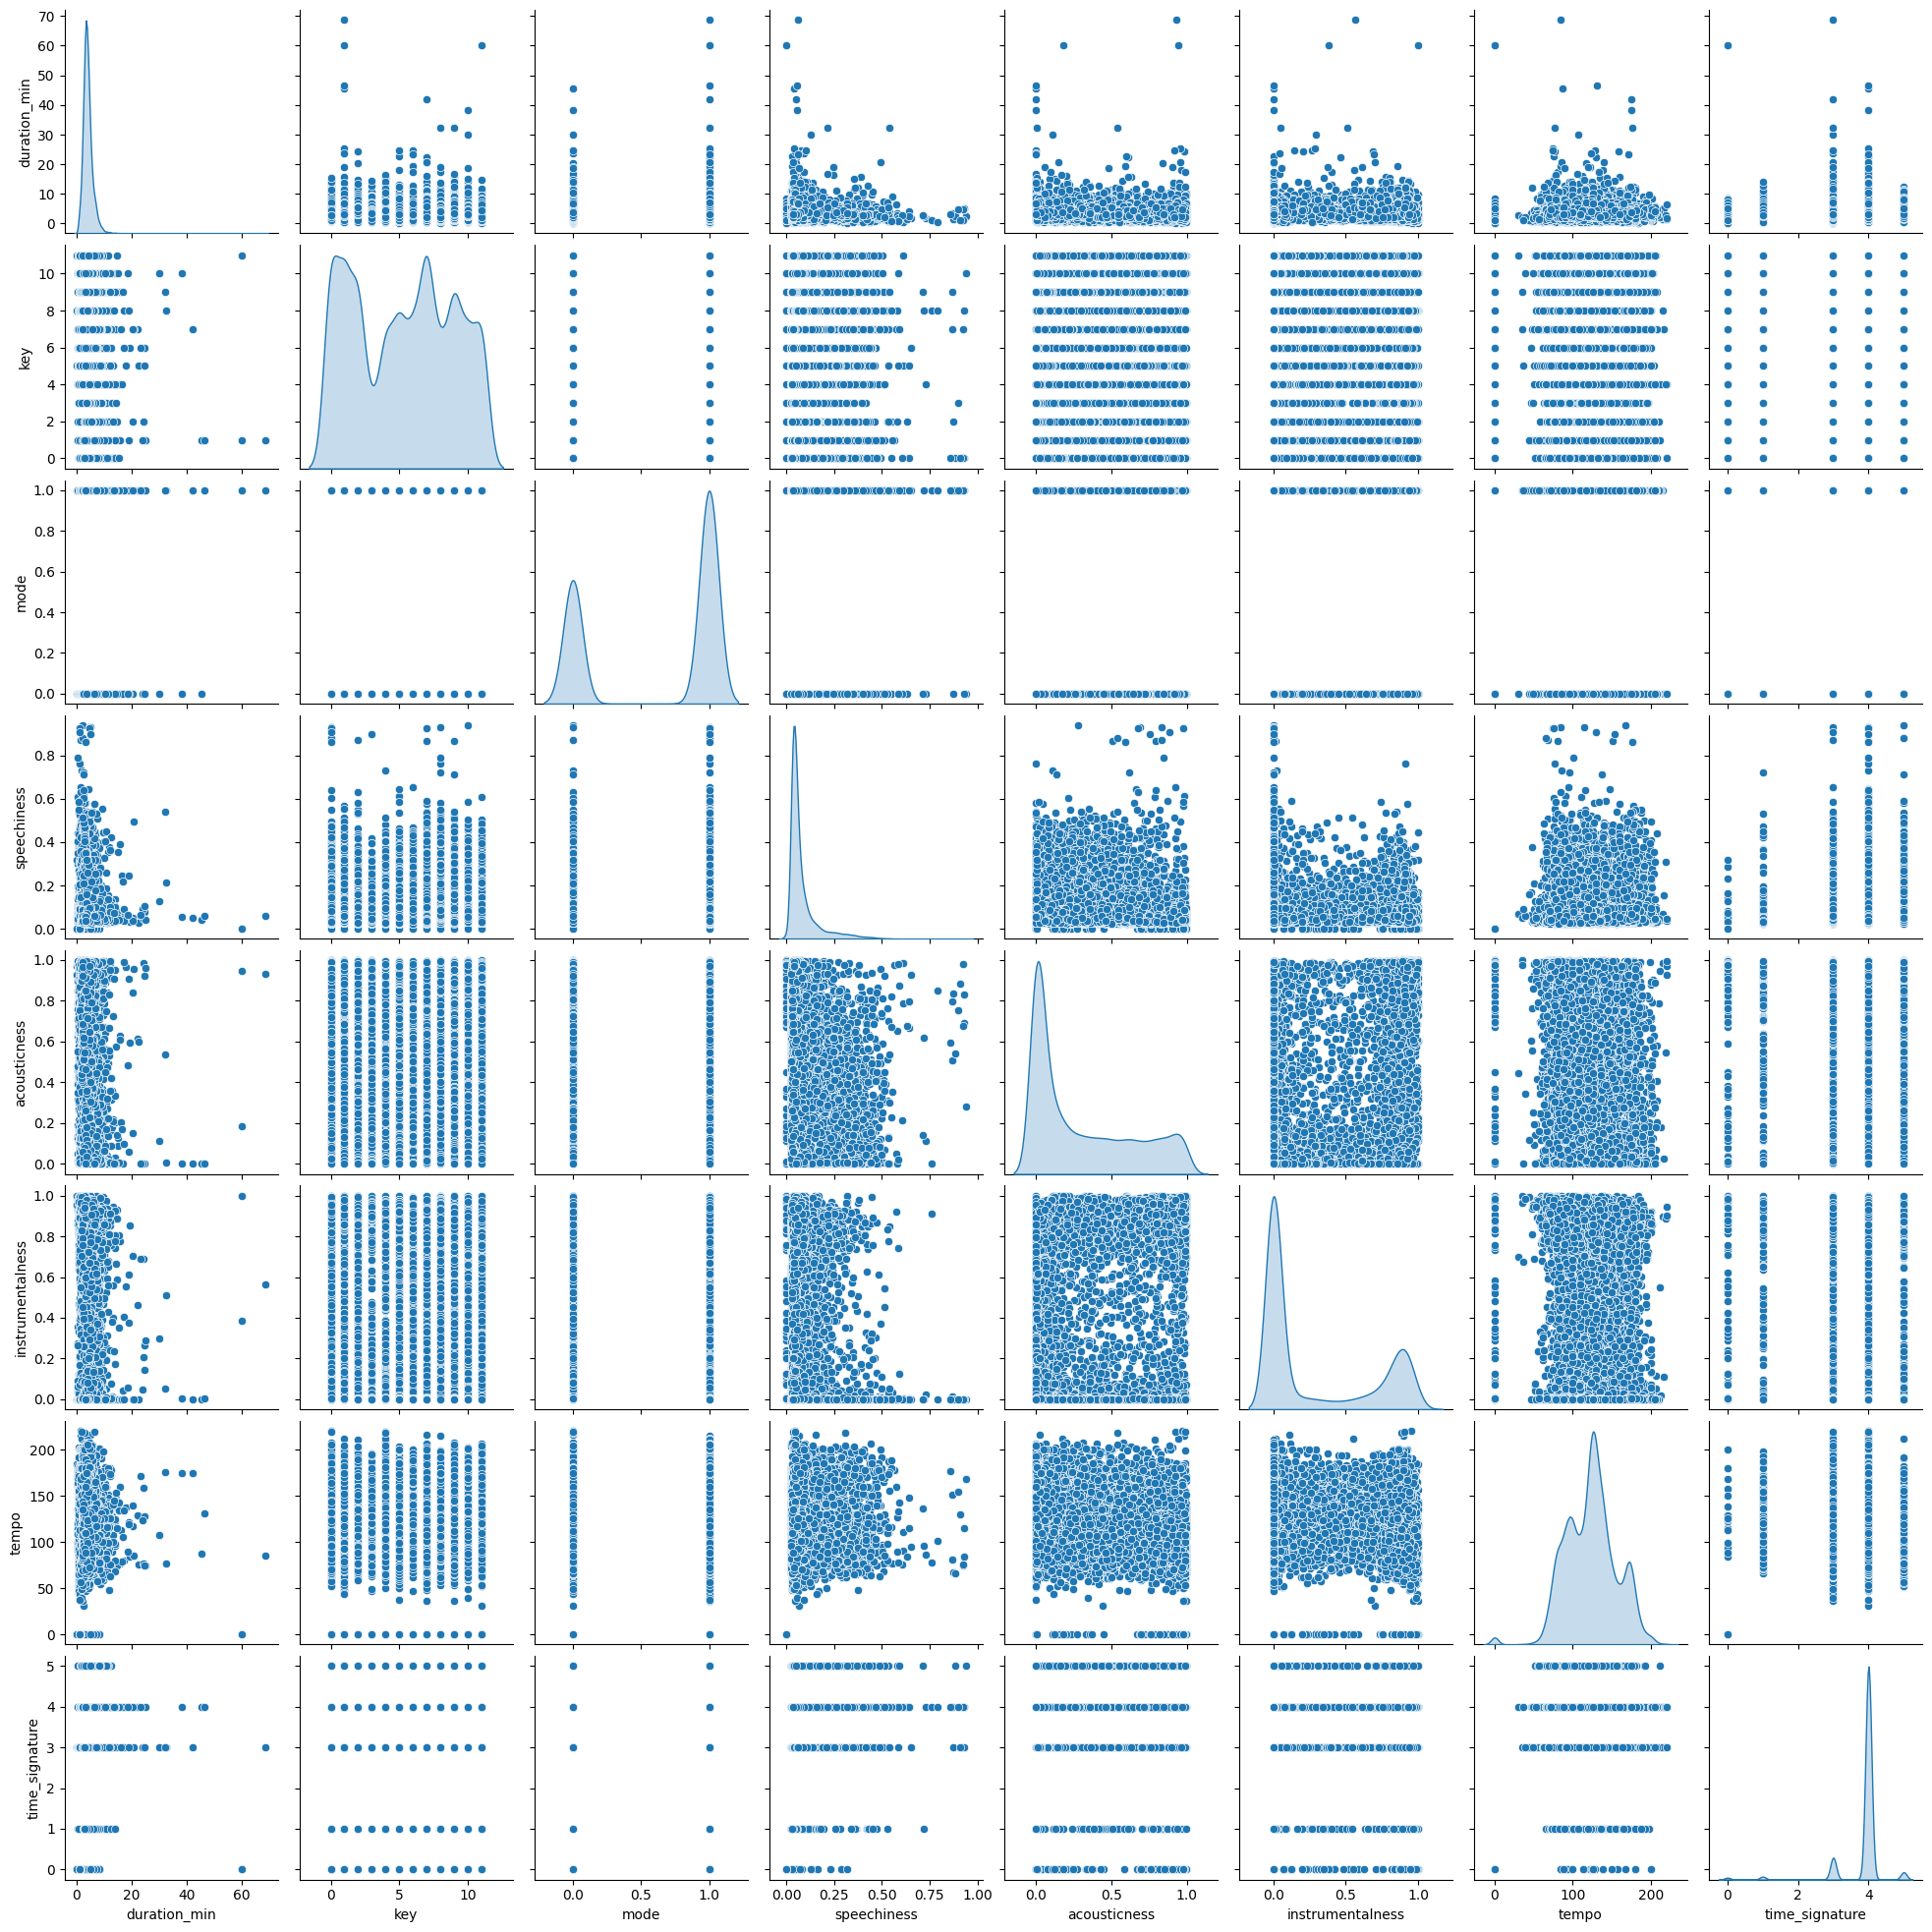

In [26]:
# let's look at distributions
sns.pairplot(dfc,diag_kind='kde')
#kde is the distribution command for diagonal plot
plt.show()

Being none of them really uniform, the chosen normalization is the _z-score_ normalization. 

In [34]:
X = dfc.values
y = np.array(df['genre'])
y_map = genre_map
#y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map)
dfc.head()

,duration_min,key,mode,speechiness,acousticness,instrumentalness,tempo,time_signature
0,4.029333,5,1.0,0.0975,0.302000,0.53600,142.221,4.0
1,7.400000,1,0.0,0.0805,0.283000,0.93400,75.596,4.0
2,5.558433,2,1.0,0.0397,0.000089,0.80000,116.628,4.0
3,4.496667,5,1.0,0.0765,0.066400,0.00127,140.880,4.0
4,5.127517,7,1.0,0.0539,0.000576,0.09690,143.956,4.0


In [35]:
#performing z-score normalization
scaler = StandardScaler()
scaler.fit(X)
X_scal = scaler.transform(X)

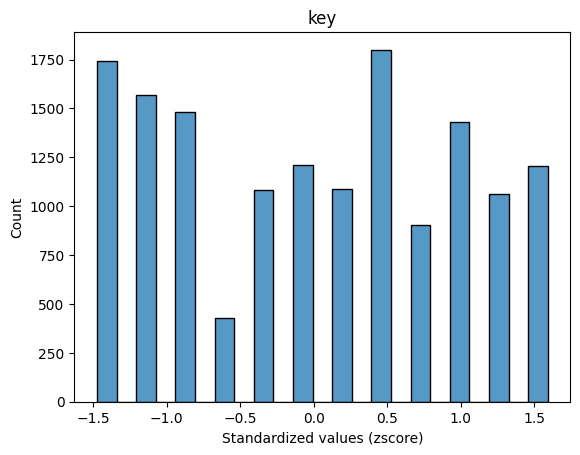

In [38]:
#just for check, plotting one of the attributes after normalization
i = 1
sns.histplot(X_scal[:,i])
plt.title(dfc.columns[i])
plt.xlabel("Standardized values (zscore)")
plt.show()